#遷移學習 resnet與inc 預測平均

### Import必要套件

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers

import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp '/content/drive/MyDrive/TFkeras/catdog.zip' /content

In [ ]:
!unzip /content/catdog.zip -d /content/

串流輸出內容已截斷至最後 5000 行。
  inflating: /content/catdog/train/dog/dog.5499.jpg  
  inflating: /content/catdog/train/dog/dog.55.jpg  
  inflating: /content/catdog/train/dog/dog.550.jpg  
  inflating: /content/catdog/train/dog/dog.5500.jpg  
  inflating: /content/catdog/train/dog/dog.5501.jpg  
  inflating: /content/catdog/train/dog/dog.5502.jpg  
  inflating: /content/catdog/train/dog/dog.5503.jpg  
  inflating: /content/catdog/train/dog/dog.5504.jpg  
  inflating: /content/catdog/train/dog/dog.5505.jpg  
  inflating: /content/catdog/train/dog/dog.5506.jpg  
  inflating: /content/catdog/train/dog/dog.5507.jpg  
  inflating: /content/catdog/train/dog/dog.5508.jpg  
  inflating: /content/catdog/train/dog/dog.5509.jpg  
  inflating: /content/catdog/train/dog/dog.551.jpg  
  inflating: /content/catdog/train/dog/dog.5510.jpg  
  inflating: /content/catdog/train/dog/dog.5511.jpg  
  inflating: /content/catdog/train/dog/dog.5512.jpg  
  inflating: /content/catdog/train/dog/dog.5513.jpg  
  inflating

### cats_vs_dogs
載入cats_vs_dogs數據集

In [ ]:
image_size = [128, 128]
batch_size = 64

In [ ]:
test_dir='/content/catdog/test/'

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
      "catdog/test",
      validation_split=0.0,
      shuffle=False,
      seed=1001,
      image_size=image_size,
      batch_size=None,
)

Found 5000 files belonging to 2 classes.


In [ ]:
labels = test_ds.class_names

In [ ]:
def parse_fn_res(x, y): # for resnet_50
    x = tf.cast(x, tf.float32)  # 影像標準化
    x = tf.keras.applications.resnet50.preprocess_input(x)
    return x, tf.one_hot(y, 2)

def parse_fn_inc(x, y): # for inception_v3
    x = tf.cast(x, tf.float32)  # 影像標準化
    x = tf.keras.applications.inception_v3.preprocess_input(x)
    return x, tf.one_hot(y, 2)

AUTOTUNE = tf.data.experimental.AUTOTUNE  # 自動調整模式

test_ds_res = test_ds.map(map_func=parse_fn_res, num_parallel_calls=AUTOTUNE)
# 設定批次大小並將prefetch模式開啟(暫存空間為自動調整模式)。
test_ds_res = test_ds_res.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

test_ds_inc = test_ds.map(map_func=parse_fn_inc, num_parallel_calls=AUTOTUNE)
# 設定批次大小並將prefetch模式開啟(暫存空間為自動調整模式)。
test_ds_inc = test_ds_inc.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

#resnet預測

In [ ]:
from sklearn.metrics import confusion_matrix
from tensorflow.keras import backend as K
import itertools

def get_conf_matrix(dataset, model, lenlab, size, image_size):
    prediction = []
    predictions = []
    true_y = []
    predictprob = np.empty([size, lenlab])

    ix = 0
    for x,y in dataset:
        prediction =  model.predict(x) # (1,2)
        predictprob[ix*batch_size:(ix+1)*batch_size,:] = prediction
        # decoding one-hot
        prediction = np.argmax(prediction, axis=1)
        y = np.argmax(y, axis =1)

        predictions = np.concatenate((predictions, prediction))
        true_y = np.concatenate((true_y, y))
        if len(predictions) >=size:
            break
        ix+=1

    matrix = confusion_matrix(true_y, predictions)

    return predictprob, matrix

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/TFkeras/resnet50.h5')
pred_resnet, conf_matrix_resnet = get_conf_matrix(test_ds_res, model, len(labels), 5000, image_size)
print(conf_matrix_resnet[:,:])
del model
K.clear_session()

1/1 [==============================] - 2s 2s/step
[[2418   82]
 [  53 2447]]


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[0.9672 0.0328]
 [0.0212 0.9788]]


0.973

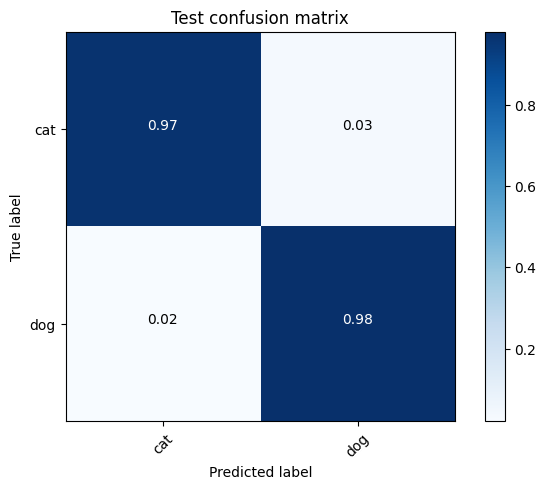

In [ ]:
plot_confusion_matrix(conf_matrix_resnet, labels, title = "Test confusion matrix")
sum([conf_matrix_resnet[i, i] for i in range(2)])/5000.0

#incv3預測

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/TFkeras/incv3.h5')
pred_inc, conf_matrix_inc = get_conf_matrix(test_ds_inc, model, len(labels), 5000, image_size)
print(conf_matrix_inc[:,:])
del model
K.clear_session()

1/1 [==============================] - 2s 2s/step
[[2402   98]
 [  46 2454]]


Normalized confusion matrix
[[0.9608 0.0392]
 [0.0184 0.9816]]


0.9712

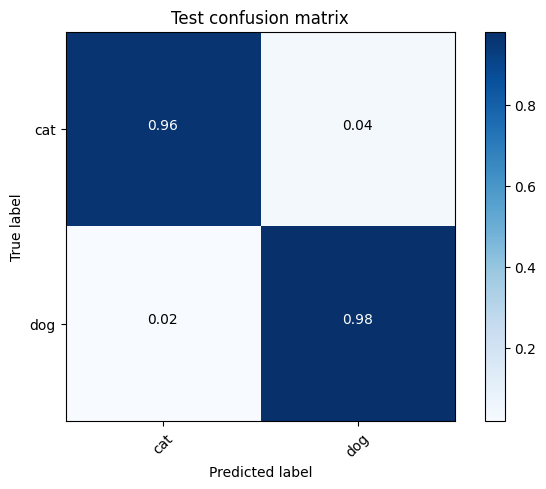

In [ ]:
plot_confusion_matrix(conf_matrix_inc, labels, title = "Test confusion matrix")
sum([conf_matrix_inc[i, i] for i in range(2)])/5000.0

#resnet與inc 預測平均

In [ ]:
true_y = []
for _,y in test_ds_inc:
    # decoding one-hot
    y = np.argmax(y, axis =1)
    true_y = np.concatenate((true_y, y))
    if len(true_y)>=5000:
        break

Normalized confusion matrix
[[0.9676 0.0324]
 [0.0184 0.9816]]


0.9746

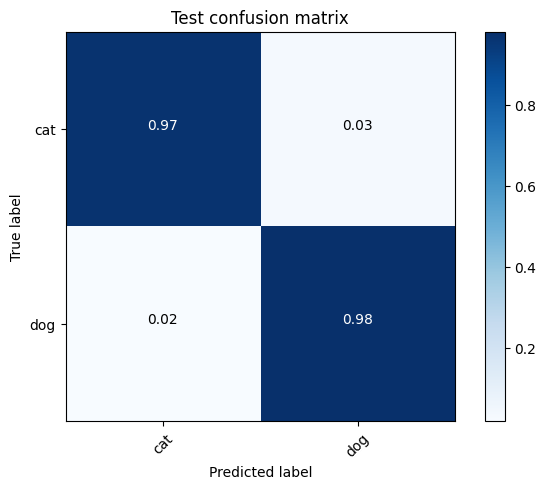

In [ ]:
predmean = (pred_resnet + pred_inc) / 2.
predictions = np.argmax(predmean, axis=1)
conf_matrix = confusion_matrix(true_y, predictions) # sklearn
plot_confusion_matrix(conf_matrix, labels, title = "Test confusion matrix")
sum([conf_matrix[i, i] for i in range(2)])/5000.